In [240]:
#This script performs several setps of time series analyis
# First section: Order selection for ARIMAX model based on lowest AIC and BIC
# Second section: Testing for model performance improvement

# The aim of our research is not to identify multicollinearity, endogeneity, the only purpose is to test in all the following scripts whether the predictive power of two different models can be improved.

import pandas as pd
import numpy as np
import random
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


import warnings
warnings.filterwarnings('ignore')
random.seed(42)

df = pd.read_csv("./tsdata/modeldata.csv", index_col='Date', parse_dates=True)
df.index.freq = "MS"


scaler = MinMaxScaler(feature_range=(0,1))
df[["returns", "msci", "sentiment"]] = scaler.fit_transform(df[["returns", "msci", "sentiment"]])

train = df[:'2020-01-01']
test = df['2020-01-02':]

In [241]:
#Model fitting
y = train['returns']
X_msci = train[["msci"]]
X_sent = train[["sentiment"]] #"sentiment" is our own sentiment score derived fromt the sentiment LDA
X_both = train[["msci","sentiment"]]#Both the MSCI and the sentiment score are included

def evaluateModel(data, exog, order):
    model = SARIMAX(data, exog=exog, order=(order[0], 0, order[1]), enforce_stationarity=True, enforce_invertibility=True)
    model_fit = model.fit(disp=False, maxiter = 300)
    return order, model_fit.aic, model_fit.bic

orders = [(p, q) for p in range(5) for q in range(5) if (p, q) != (0, 0)]

results_base = []
results_msci = []
results_sent = []
results_both = []

#Base model
for order in orders:
    try:
        order, aic, bic = evaluateModel(y, None, order)
        results_base.append([order, aic, bic])
    except Exception as e:
        print(f"Order {order} for base model failed: {e}")


#Including MSCI
for order in orders:
    try:
        order, aic_msci, bic_msci = evaluateModel(y, X_msci, order)
        results_msci.append([order, aic_msci, bic_msci])
    except Exception as e:
        print(f"Order {order} with msci failed: {e}")

#Including own sentiment score
for order in orders:
    try:
        order, aic_sent, bic_sent = evaluateModel(y, X_sent, order)
        results_sent.append([order, aic_sent, bic_sent])
    except Exception as e:
        print(f"Order {order} with sentiment failed: {e}")


#Including both scores
for order in orders:
    try:
        order, aic_both, bic_both = evaluateModel(y, X_both, order)
        results_both.append([order, aic_both, bic_both])
    except Exception as e:
        print(f"Order {order} with both variables failed: {e}")


df_base = pd.DataFrame(results_base, columns=['Order', 'AIC', 'BIC'])
df_msci = pd.DataFrame(results_msci, columns=['Order', 'AIC', 'BIC'])
df_sent = pd.DataFrame(results_sent, columns=['Order', 'AIC', 'BIC'])
df_both = pd.DataFrame(results_both, columns=['Order', 'AIC', 'BIC'])

In [242]:
min_aic_base_index = df_base['AIC'].idxmin()
min_bic_base_index = df_base['BIC'].idxmin()

min_aic_base_order = df_base.loc[min_aic_base_index]
min_bic_base_order = df_base.loc[min_bic_base_index]


min_aic_msci_index = df_msci['AIC'].idxmin()
min_bic_msci_index = df_msci['BIC'].idxmin()

min_aic_msci_order = df_msci.loc[min_aic_msci_index]
min_bic_msci_order = df_msci.loc[min_bic_msci_index]


min_aic_sent_index = df_sent['AIC'].idxmin()
min_bic_sent_index = df_sent['BIC'].idxmin()

min_aic_sent_order = df_sent.loc[min_aic_sent_index]
min_bic_sent_order = df_sent.loc[min_bic_sent_index]


min_aic_both_index = df_both['AIC'].idxmin()
min_bic_both_index = df_both['BIC'].idxmin()

min_aic_both_order = df_both.loc[min_aic_both_index]
min_bic_both_order = df_both.loc[min_bic_both_index]


# Printing the results
print("Base model with lowest AIC:", min_aic_base_order)
print("Base model with lowest BIC:", min_bic_base_order)



print("MSCI model with lowest AIC:", min_bic_msci_order)
print("MSCI model with lowest BIC:", min_bic_msci_order)


print("Sent model with lowest AIC:", min_bic_sent_order)
print("Sent model with lowest BIC:", min_bic_sent_order)


print("Both model with lowest AIC:", min_bic_both_order)
print("Both model with lowest BIC:", min_bic_both_order)

Base model with lowest AIC: Order       (1, 1)
AIC     -64.027491
BIC     -56.272589
Name: 5, dtype: object
Base model with lowest BIC: Order       (1, 1)
AIC     -64.027491
BIC     -56.272589
Name: 5, dtype: object
MSCI model with lowest AIC: Order       (1, 1)
AIC     -62.044113
BIC     -51.704243
Name: 5, dtype: object
MSCI model with lowest BIC: Order       (1, 1)
AIC     -62.044113
BIC     -51.704243
Name: 5, dtype: object
Sent model with lowest AIC: Order       (1, 1)
AIC     -62.232056
BIC     -51.892186
Name: 5, dtype: object
Sent model with lowest BIC: Order       (1, 1)
AIC     -62.232056
BIC     -51.892186
Name: 5, dtype: object
Both model with lowest AIC: Order       (1, 1)
AIC     -60.236945
BIC     -47.312108
Name: 5, dtype: object
Both model with lowest BIC: Order       (1, 1)
AIC     -60.236945
BIC     -47.312108
Name: 5, dtype: object


In [243]:
basemodel = SARIMAX(y, None, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
basefit = basemodel.fit(disp=False, maxiter = 300)
basefit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   98
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  35.014
Date:                Sat, 20 Apr 2024   AIC                            -64.027
Time:                        12:09:13   BIC                            -56.273
Sample:                    12-01-2011   HQIC                           -60.891
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   7.99e-06   1.25e+05      0.000       1.000       1.000
ma.L1         -0.9990      0.062    -16.006      0.000      -1.121      -0.877
sigma2         0.0268      0.004      5.966      0.000       0.018       0.036
===================================================================================
Ljung-Box (L1) (Q):                   1.59   Jarque-Bera (JB):                 4.07
Prob(Q):                              0.21   Prob(JB):                         0.13
Heteroskedasticity (H):               1.11   Skew:                            -0.49
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [244]:
acorr_ljungbox(basefit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,8.836691,0.547669


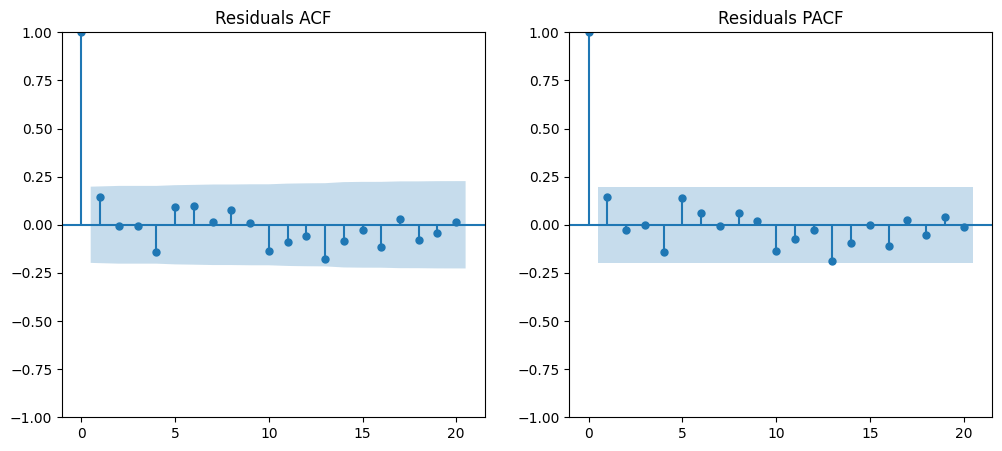

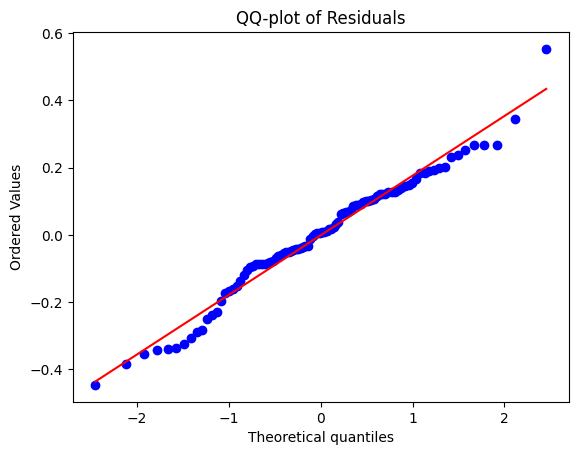

In [245]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(basefit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(basefit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(basefit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [246]:
mscimodel = SARIMAX(y, X_msci, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
mscifit = mscimodel.fit(disp=False, maxiter = 300)
mscifit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   98
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  35.022
Date:                Sat, 20 Apr 2024   AIC                            -62.044
Time:                        12:09:14   BIC                            -51.704
Sample:                    12-01-2011   HQIC                           -57.862
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
msci          -0.0125      0.110     -0.114      0.910      -0.229       0.204
ar.L1          1.0000   1.74e-05   5.76e+04      0.000       1.000       1.000
ma.L1         -0.9989      0.120     -8.302      0.000      -1.235      -0.763
sigma2         0.0268      0.006      4.836      0.000       0.016       0.038
===================================================================================
Ljung-Box (L1) (Q):                   1.60   Jarque-Bera (JB):                 4.08
Prob(Q):                              0.21   Prob(JB):                         0.13
Heteroskedasticity (H):               1.11   Skew:                            -0.49
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [247]:
acorr_ljungbox(mscifit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,8.748822,0.556096


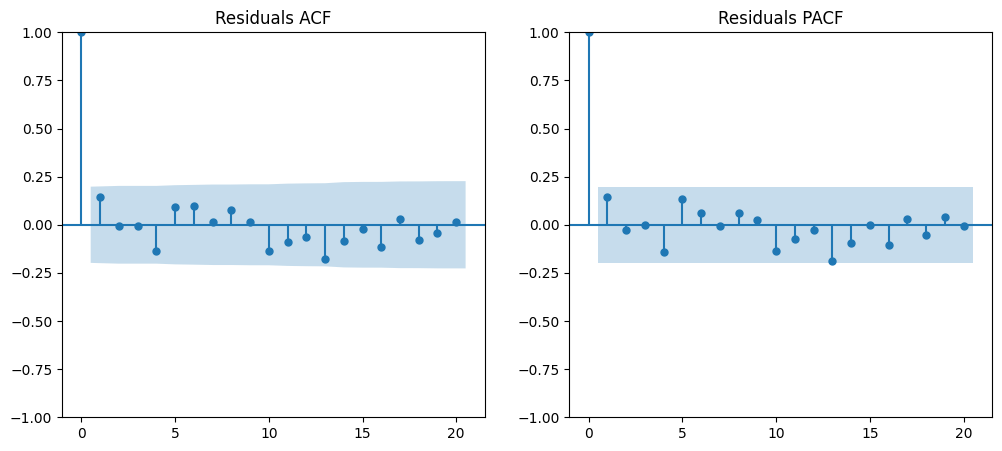

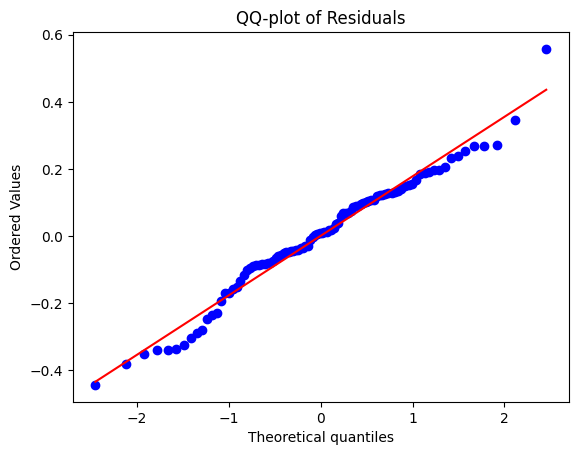

In [248]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(mscifit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(mscifit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(mscifit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [249]:
sentmodel = SARIMAX(y, X_sent, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
sentfit = sentmodel.fit(disp=False, maxiter = 300)
sentfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   98
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  35.116
Date:                Sat, 20 Apr 2024   AIC                            -62.232
Time:                        12:09:15   BIC                            -51.892
Sample:                    12-01-2011   HQIC                           -58.050
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sentiment      0.0306      0.063      0.489      0.625      -0.092       0.153
ar.L1          1.0000    2.5e-06      4e+05      0.000       1.000       1.000
ma.L1         -0.9992      0.023    -42.698      0.000      -1.045      -0.953
sigma2         0.0268      0.004      6.456      0.000       0.019       0.035
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                 4.13
Prob(Q):                              0.25   Prob(JB):                         0.13
Heteroskedasticity (H):               1.09   Skew:                            -0.49
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [250]:
acorr_ljungbox(sentfit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,8.779498,0.55315


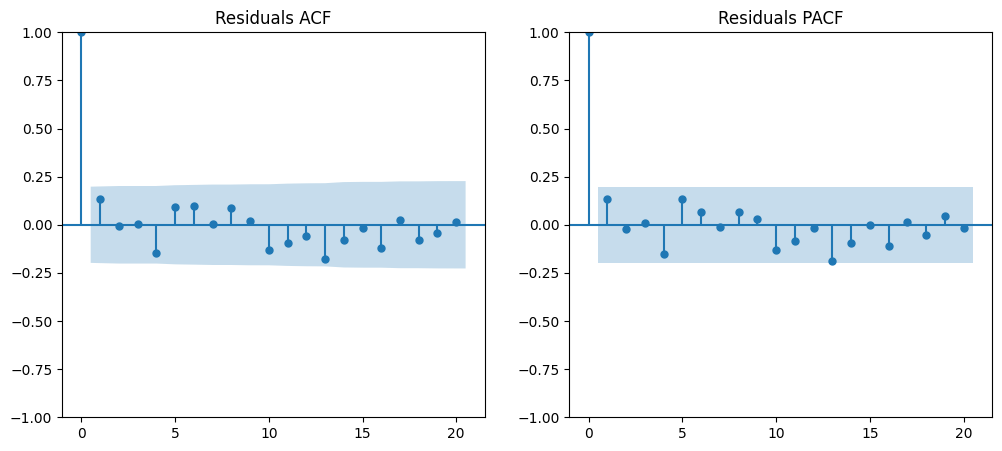

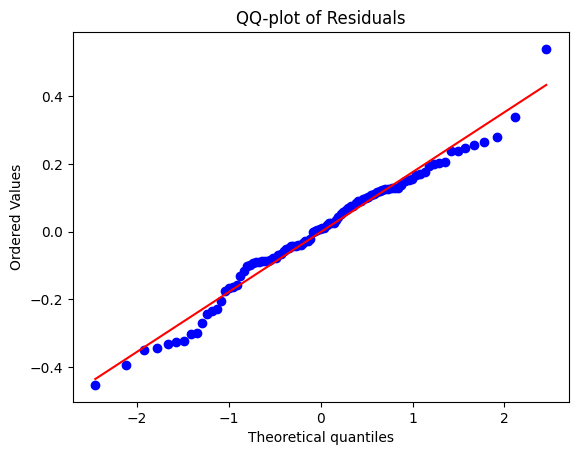

In [251]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(sentfit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(sentfit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(sentfit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [252]:
bothmodel = SARIMAX(y, X_both, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
bothfit = bothmodel.fit(disp=False, maxiter = 300)
bothfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   98
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  35.118
Date:                Sat, 20 Apr 2024   AIC                            -60.237
Time:                        12:09:15   BIC                            -47.312
Sample:                    12-01-2011   HQIC                           -55.009
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
msci          -0.0069      0.111     -0.063      0.950      -0.224       0.210
sentiment      0.0302      0.063      0.480      0.631      -0.093       0.154
ar.L1          1.0000    3.7e-06    2.7e+05      0.000       1.000       1.000
ma.L1         -0.9992      0.033    -30.702      0.000      -1.063      -0.935
sigma2         0.0267      0.004      6.011      0.000       0.018       0.035
===================================================================================
Ljung-Box (L1) (Q):                   1.33   Jarque-Bera (JB):                 4.13
Prob(Q):                              0.25   Prob(JB):                         0.13
Heteroskedasticity (H):               1.09   Skew:                            -0.50
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [253]:
acorr_ljungbox(bothfit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,8.738256,0.557111


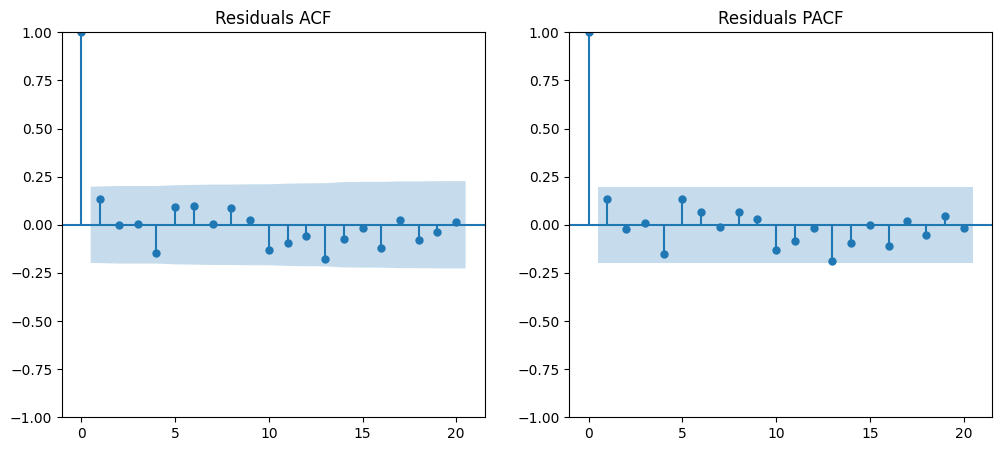

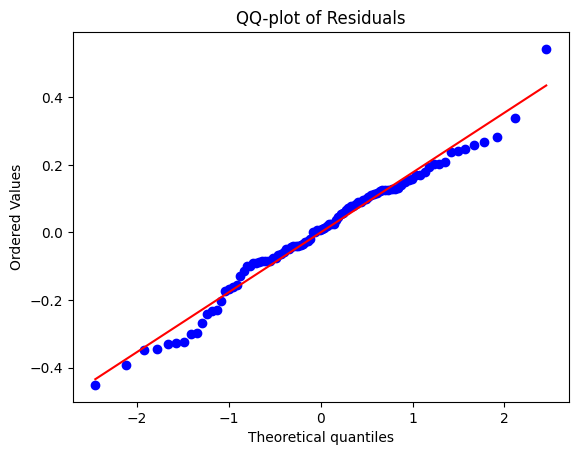

In [254]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(bothfit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(bothfit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(bothfit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [255]:
ytest = test["returns"]

Xmsci_test = test[["msci"]]
Xsent_test = test[["sentiment"]]
Xboth_test = test[["msci", "sentiment"]]


pbase = basefit.get_forecast(steps=len(ytest), exog=None).predicted_mean
pmsci = mscifit.get_forecast(steps=len(ytest), exog=Xmsci_test).predicted_mean
psent = sentfit.get_forecast(steps=len(ytest), exog=Xsent_test).predicted_mean
pboth = bothfit.get_forecast(steps=len(ytest), exog=Xboth_test).predicted_mean

def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))


errors = {
    'Model': ['Base', 'MSCI', 'Sentiment', 'Both'],
    'MAPE': [mape(ytest, pbase), mape(ytest, pmsci), mape(ytest, psent), mape(ytest, pboth)],
    'RMSE': [rmse(ytest, pbase), rmse(ytest, pmsci), rmse(ytest, psent), rmse(ytest, pboth)]
}

results_df = pd.DataFrame(errors)
print(results_df)

       Model        MAPE      RMSE
0       Base  512.793855  0.268710
1       MSCI  518.783833  0.268897
2  Sentiment  501.734909  0.269067
3       Both  505.176903  0.269125


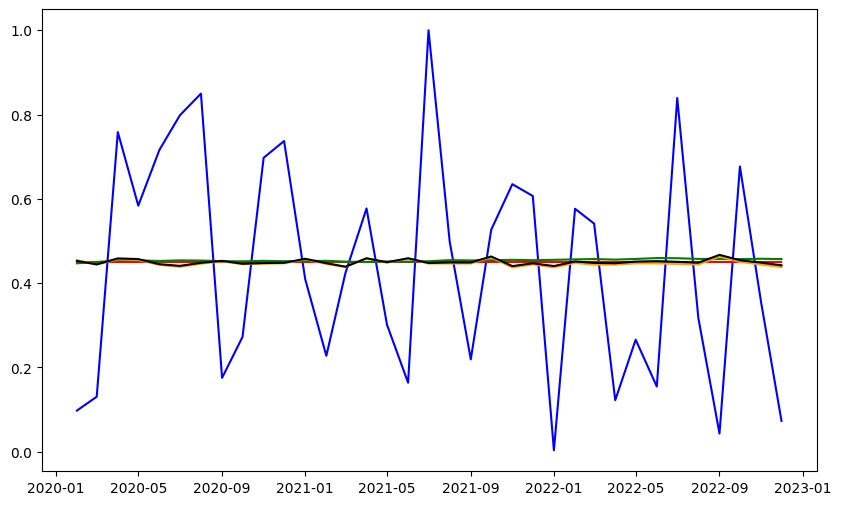

In [256]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, ytest, label='Actual', color='blue')
plt.plot(test.index, pbase, label='Base Model', color='red')
plt.plot(test.index, pmsci, label='MSCI Model', color='green')
plt.plot(test.index, psent, label='Sentiment Score Model', color='orange')
plt.plot(test.index, pboth, label='Both Exo Model', color='black')
